In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from model_chain import run_chain_of_models, get_ace_date
from SA_tools.sobol import estimate_sobol
import datetime as dt
import astropy.units as u
from scipy.stats import pearsonr
from sunpy.coordinates.sun import carrington_rotation_time
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib
import matplotlib.dates as mdates
font = {'family' : 'serif',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [5]:
# set up carrington rotation
CR = "2058"
start_time = carrington_rotation_time(int(CR)).to_datetime()
end_time = carrington_rotation_time(int(CR)+1).to_datetime()

# get ace data
ACE_longitude, ACE_latitude, ACE_r, ACE_vr, ACE_obstime = get_ace_date(start_time=start_time, end_time=end_time)
ACE_vr_is_nan = np.isnan(ACE_vr)

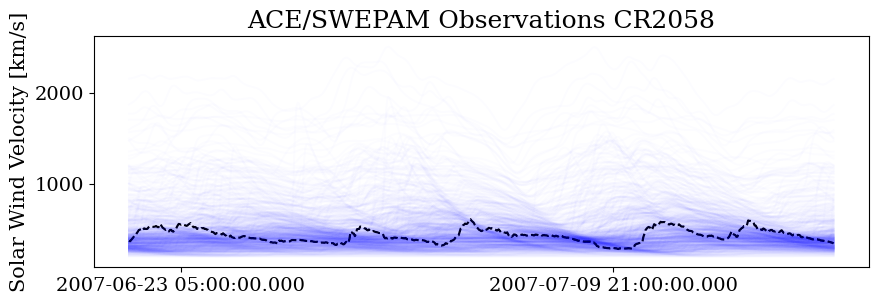

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(ACE_obstime.value, ACE_vr, c="k", ls="--")
ax.set_ylabel("Solar Wind Velocity [km/s]")
ax.set_title("ACE/SWEPAM Observations CR" + str(CR))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=400))


for ii in range(614):
    vr_hux_wsa_interp = np.load(file=os.getcwd() + "/SA_results/CR" + str(CR) + "/LHS" + "/simulation_output/A" + str(ii) + "/vr_hux_sample_A" + str(ii) + ".npy")
    ax.plot(ACE_obstime.value, vr_hux_wsa_interp, alpha=0.01, c="b")
    

In [7]:
# directory with results
dir_name = os.getcwd() + "/SA_results/CR" + str(CR) + "/LHS"

N=10000
d=11

In [8]:
# initialize matrices.
YA_RMSE = np.zeros(N)
YB_RMSE = np.zeros(N)
YC_RMSE = np.zeros((N, d))

YA_MAE = np.zeros(N)
YB_MAE = np.zeros(N)
YC_MAE = np.zeros((N, d))

YA_PCC = np.zeros(N)
YB_PCC = np.zeros(N)
YC_PCC = np.zeros((N, d))

YA_DTW = np.zeros(N)
YB_DTW = np.zeros(N)
YC_DTW = np.zeros((N, d))

In [9]:
for ii in range(N):
    try:
        vr_hux_wsa_interp = np.load(file=dir_name + "/simulation_output/A" + str(ii) + "/vr_hux_sample_A" + str(ii) + ".npy")
        YA_RMSE[ii], YA_MAE[ii], YA_PCC[ii] = [np.sqrt(np.mean((vr_hux_wsa_interp[~ACE_vr_is_nan] - ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan]) ** 2)),
                                               np.mean(np.abs(vr_hux_wsa_interp[~ACE_vr_is_nan] - ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan])),
                                               pearsonr(vr_hux_wsa_interp[~ACE_vr_is_nan], ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan])[0]]
        #YA_DTW[ii] = fastdtw(ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan], vr_hux_wsa_interp[~ACE_vr_is_nan], dist=euclidean)[0]
    except:
        print(ii)

In [10]:
for ii in range(N):
    vr_hux_wsa_interp = np.load(file=dir_name + "/simulation_output/B"+ str(ii) + "/vr_hux_sample_B" + str(ii) + ".npy")
    YB_RMSE[ii], YB_MAE[ii], YB_PCC[ii] = [np.sqrt(np.mean((vr_hux_wsa_interp[~ACE_vr_is_nan] - ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan]) ** 2)),
                                           np.mean(np.abs(vr_hux_wsa_interp[~ACE_vr_is_nan] - ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan])),
                                           pearsonr(vr_hux_wsa_interp[~ACE_vr_is_nan], ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan])[0]]
    #YB_DTW[ii] = fastdtw(ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan], vr_hux_wsa_interp[~ACE_vr_is_nan], dist=euclidean)[0]

In [11]:
for ii in range(N):
     for jj in range(d):
        try:
            vr_hux_wsa_interp = np.load(file=dir_name + "/simulation_output/C"+ str(ii) + "_" + str(jj) +"/vr_hux_sample_C" + str(ii) + "_" + str(jj) + ".npy")
            YC_RMSE[ii, jj], YC_MAE[ii, jj], YC_PCC[ii, jj] = [np.sqrt(np.mean((vr_hux_wsa_interp[~ACE_vr_is_nan] - ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan]) ** 2)),
                                               np.mean(np.abs(vr_hux_wsa_interp[~ACE_vr_is_nan] - ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan])),
                                               pearsonr(vr_hux_wsa_interp[~ACE_vr_is_nan], ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan])[0]]
            #YC_DTW[ii, jj] = fastdtw(ACE_vr.to(u.km / u.s).value[~ACE_vr_is_nan], vr_hux_wsa_interp[~ACE_vr_is_nan], dist=euclidean)[0]
        except:
            print(ii, jj)

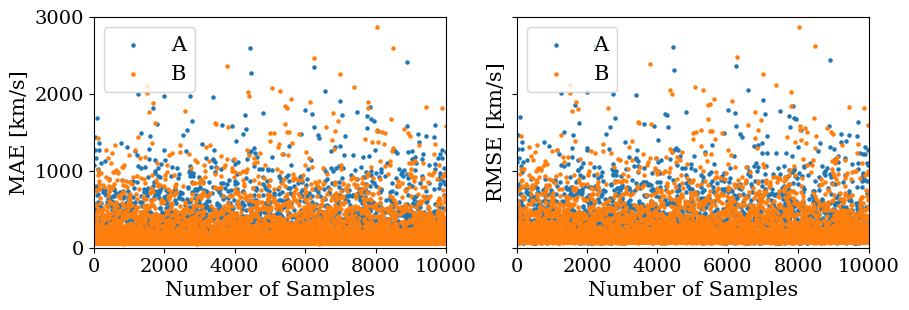

In [12]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 3))
ax[0].scatter(np.arange(N), YA_MAE,  s=5, label="A")
ax[0].scatter(np.arange(N), YB_MAE, s=5, label="B")
ax[0].set_ylabel("MAE [km/s]")
ax[0].set_xlim(0, N)
ax[0].set_ylim(0, 3000)
ax[0].legend()


ax[1].scatter(np.arange(N), YA_RMSE,  s=5, label="A")
ax[1].scatter(np.arange(N), YB_RMSE, s=5, label="B")
ax[1].set_ylabel("RMSE [km/s]")
ax[1].set_xlim(0, N)
ax[1].set_ylim(0, 3000)
ax[1].set_xlabel("Number of Samples")
ax[0].set_xlabel("Number of Samples")
ax[1].legend()

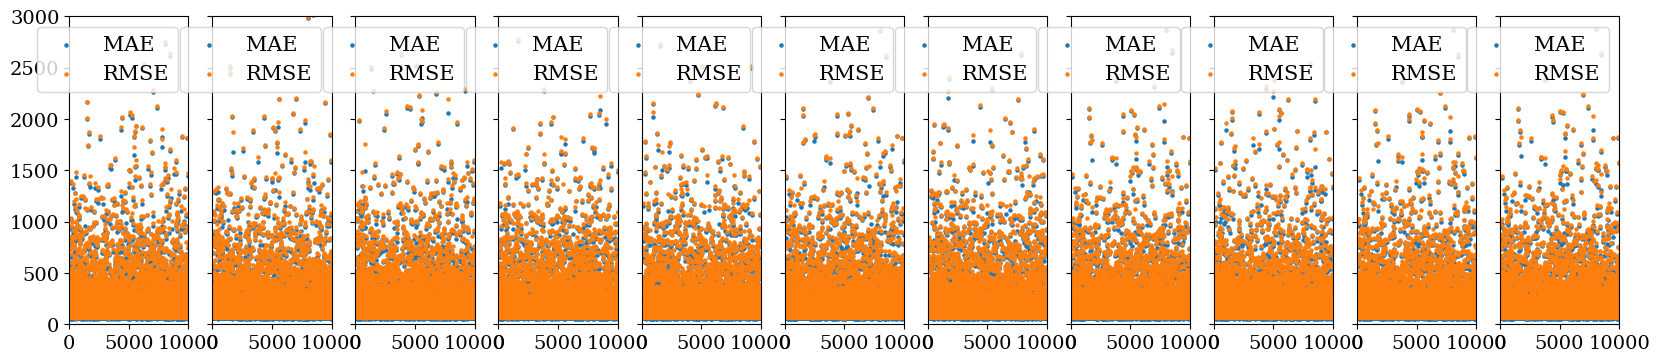

In [13]:
fig, ax = plt.subplots(ncols=d, sharex=True, sharey=True, figsize=(20, 4))
for jj in range(d):
    ax[jj].scatter(np.arange(N), YC_MAE[:, jj],  s=5, label="MAE")
    ax[jj].scatter(np.arange(N), YC_RMSE[:, jj],  s=5, label="RMSE")
    ax[jj].set_xlim(0, N)
    ax[jj].set_ylim(0, 3000)
    ax[jj].legend()

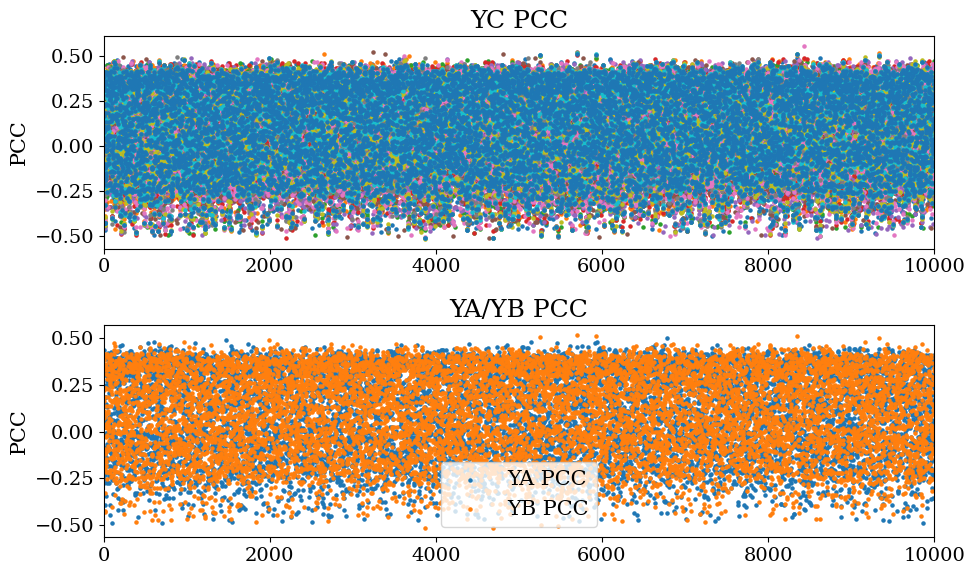

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
for jj in range(d):
    ax[0].scatter(np.arange(N), YC_PCC[:, jj],  s=5, label="PCC " + str(jj))
ax[0].set_ylabel("PCC")
ax[0].set_xlim(0, N)
ax[0].set_title("YC PCC")

ax[1].scatter(np.arange(N), YA_PCC,  s=5, label="YA PCC")
ax[1].scatter(np.arange(N), YB_PCC,  s=5, label="YB PCC")
ax[1].set_ylabel("PCC")
ax[1].set_xlim(0, N)
ax[1].set_title("YA/YB PCC")
ax[1].legend()
plt.tight_layout()

In [15]:
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_RMSE/YA", arr=YA_RMSE)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_MAE/YA", arr=YA_MAE)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_PCC/YA", arr=YA_PCC)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_DTW/YA", arr=YA_DTW)

np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_RMSE/YB", arr=YB_RMSE)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_MAE/YB", arr=YB_MAE)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_PCC/YB", arr=YB_PCC)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_DTW/YB", arr=YB_DTW)

np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_RMSE/YC", arr=YC_RMSE)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_MAE/YC", arr=YC_MAE)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_PCC/YC", arr=YC_PCC)
np.save(file="SA_results/CR" + str(CR) + "/LHS/simulation_DTW/YC", arr=YC_DTW)